# Summary
This notebook builds and evaluates three machine learning models (Random Forest, SVM, and XGBoost) for classifying patients into triage levels based on preprocessed hospital data. The best model is selected based on performance metrics.

## Imports

In [85]:
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score
)

import joblib

## Data Cleaning and Preprocessing

In [ ]:
# Load dataset
df = pd.read_csv("MSE 436 Dataset.csv", encoding='latin1', delimiter=';')

# Replace problematic values with NaN
df.replace({'??': np.nan, '#BOÞ!': np.nan, '#REF!': np.nan}, inplace=True)

# Convert to numeric where possible
numeric_cols = ['Age', 'NRS_pain', 'SBP', 'DBP', 'HR', 'RR', 'BT', 'Saturation']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop irrelevant or very sparse columns
drop_cols = [
    'Group', 'Patients number per hour', 'Diagnosis in ED', 'Disposition',
    'Error_group', 'Length of stay_min', 'KTAS duration_min', 'mistriage',
    'Chief_complain'
]
df.drop(columns=drop_cols, inplace=True, errors='ignore')

# Fill missing values with column medians (this may be throwing off our model)
df.fillna(df.median(numeric_only=True), inplace=True)

# Encode categorical features:
df['Sex_Male'] = (df['Sex'] == 1).astype(int)
df['Injury_Yes'] = (df['Injury'] == 1).astype(int)
df['Pain_Yes'] = (df['Pain'] == 1).astype(int)
df['Mental_ord'] = df['Mental']

# Final dataset for training, etc
df.drop(columns=['Sex', 'Injury', 'Pain', 'Arrival mode', 'Mental'], inplace=True, errors='ignore')
df = df[df['KTAS_expert'].notna()]

# Define features and target, focus on KTAS results
X = df.drop(columns=['KTAS_expert'])
y = df['KTAS_expert'].astype(int) - 1  # shift to 0–4

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Scale numeric features to be equal
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Label encode the target
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Compute class weights to use for very uneven classes (another place that is messing up results)
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weight_dict = dict(zip(classes, weights))

In [58]:
df.to_csv('cleaned.csv', index=True)

## Random Forest

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.85      0.77      0.81        44
           2       0.91      0.89      0.90        98
           3       0.86      0.96      0.91        92
           4       0.77      0.67      0.71        15

    accuracy                           0.87       254
   macro avg       0.88      0.78      0.82       254
weighted avg       0.87      0.87      0.87       254



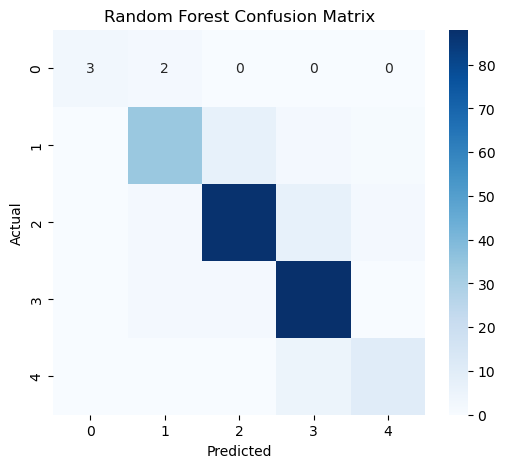

In [78]:
# Train Random Forest model
rf_model = RandomForestClassifier(class_weight=class_weight_dict, n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_preds = rf_model.predict(X_test_scaled)

# Evaluation Metrics
rf_accuracy = accuracy_score(y_test, rf_preds)
rf_f1_macro = f1_score(y_test, rf_preds, average='macro')
rf_f1_weighted = f1_score(y_test, rf_preds, average='weighted')

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_preds))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save for comparison
rf_metrics = {
    "model": rf_model,
    "name": "Random Forest",
    "accuracy": rf_accuracy,
    "f1_macro": rf_f1_macro,
    "f1_weighted": rf_f1_weighted
}


## Support Vector Machine (SVM)

SVM Accuracy: 0.8622
SVM AUC Score: 0.9612


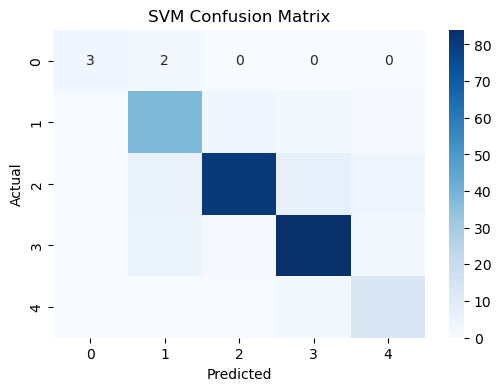

,precision,recall,f1-score,support
0,1.000000,0.600000,0.750000,5.000000
1,0.745098,0.863636,0.800000,44.000000
2,0.952941,0.826531,0.885246,98.000000
3,0.884211,0.913043,0.898396,92.000000
4,0.650000,0.866667,0.742857,15.000000
accuracy,0.862205,0.862205,0.862205,0.862205
macro avg,0.846450,0.813975,0.815300,254.000000
weighted avg,0.875078,0.862205,0.864171,254.000000


In [81]:
# Train SVM (with probability=True for predict_proba, help account for weird class weights)
svm_model = SVC(class_weight=class_weight_dict, kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Predict
svm_preds = svm_model.predict(X_test_scaled)
svm_probs = svm_model.predict_proba(X_test_scaled)

# Evaluation Metrics
svm_acc = accuracy_score(y_test, svm_preds)
svm_report = classification_report(y_test, svm_preds, output_dict=True)
svm_conf_matrix = confusion_matrix(y_test, svm_preds)

# AUC Score (macro-average for multiclass)
svm_auc = roc_auc_score(
    y_test, svm_probs, multi_class='ovo', average='macro'
)

print(f"SVM Accuracy: {svm_acc:.4f}")
print(f"SVM AUC Score: {svm_auc:.4f}")

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(svm_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report Table
svm_report_df = pd.DataFrame(svm_report).transpose()
display(svm_report_df)

## XGBoost

In [82]:
# Train XGBoost model
xgb_model = XGBClassifier(
    class_weight=class_weight_dict,
    objective='multi:softprob',
    num_class=len(np.unique(y_train)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train)

# Predictions
xgb_preds = xgb_model.predict(X_test_scaled)

# Metrics
xgb_accuracy = accuracy_score(y_test, xgb_preds)
xgb_precision = precision_score(y_test, xgb_preds, average='weighted')
xgb_recall = recall_score(y_test, xgb_preds, average='weighted')
xgb_f1 = f1_score(y_test, xgb_preds, average='weighted')

print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_preds))
print("Confusion Matrix:")
print(confusion_matrix(y_test, xgb_preds))
print(f"Accuracy: {xgb_accuracy:.3f}")
print(f"Precision: {xgb_precision:.3f}")
print(f"Recall: {xgb_recall:.3f}")
print(f"F1 Score: {xgb_f1:.3f}")

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.85      0.77      0.81        44
           2       0.91      0.91      0.91        98
           3       0.89      0.93      0.91        92
           4       0.69      0.73      0.71        15

    accuracy                           0.88       254
   macro avg       0.87      0.79      0.82       254
weighted avg       0.88      0.88      0.88       254

Confusion Matrix:
[[ 3  2  0  0  0]
 [ 0 34  6  3  1]
 [ 0  2 89  4  3]
 [ 0  2  3 86  1]
 [ 0  0  0  4 11]]
Accuracy: 0.878
Precision: 0.879
Recall: 0.878
F1 Score: 0.877


## Model Evaluation and Auto-Selection

In [84]:
# Dictionary to hold scores and model objects
model_scores = {}
model_objects = {
    "Random Forest": rf_model,
    "SVM": svm_model,
    "XGBoost": xgb_model
}
model_preds = {
    "Random Forest": rf_preds,
    "SVM": svm_preds,
    "XGBoost": xgb_preds
}

# Function to evaluate model
def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    model_scores[name] = {
        'Accuracy': acc,
        'Precision (macro)': prec,
        'Recall (macro)': rec,
        'F1-score (macro)': f1
    }
    print(f"\n{name} Classification Report:\n")
    print(classification_report(y_true, y_pred, zero_division=0))

# Evaluate all models
for name, preds in model_preds.items():
    evaluate_model(name, y_test, preds)

# Compare metrics
scores_df = pd.DataFrame(model_scores).T
display(scores_df.style.highlight_max(color='green', axis=0))

# Select best model
best_model_name = scores_df['F1-score (macro)'].idxmax()
best_model = model_objects[best_model_name]

# Save best model to .pkl for Streamlit
joblib.dump(best_model, "best_triage_model.pkl")


Random Forest Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.85      0.77      0.81        44
           2       0.91      0.89      0.90        98
           3       0.86      0.96      0.91        92
           4       0.77      0.67      0.71        15

    accuracy                           0.87       254
   macro avg       0.88      0.78      0.82       254
weighted avg       0.87      0.87      0.87       254


SVM Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.75      0.86      0.80        44
           2       0.95      0.83      0.89        98
           3       0.88      0.91      0.90        92
           4       0.65      0.87      0.74        15

    accuracy                           0.86       254
   macro avg       0.85      0.81      0.82       254
weighted 

,Accuracy,Precision (macro),Recall (macro),F1-score (macro)
Random Forest,0.874016,0.877645,0.776734,0.815587
SVM,0.862205,0.846450,0.813975,0.815300
XGBoost,0.877953,0.866452,0.789801,0.817483


['best_triage_model.pkl']